# Query Apache Iceberg Tables with PyIceberg + DuckDB + JupySQL

This notebook demonstrates querying Iceberg tables using:
- **PyIceberg** - Connect to Nessie catalog and read Iceberg tables
- **DuckDB** - Fast analytical SQL engine
- **JupySQL** - SQL magic commands for Jupyter notebooks

## Prerequisites
```bash
pip install pyiceberg[s3fs,pyarrow] duckdb jupysql duckdb-engine pandas
```

In [34]:
# Install required packages using %pip magic (works better in notebooks)
%pip install "pyiceberg[s3fs,pyarrow]" duckdb jupysql duckdb-engine pandas python-dotenv -q


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## 1. Setup and Configuration

In [41]:
# Configuration for Nessie + Cloudflare R2
# Update these values for your own setup or load it from environment variable

NESSIE_URI = 'https://nessie-iceberg.fly.dev/iceberg/'
WAREHOUSE_PATH = 's3://iceberg-demo/warehouse'
S3_ENDPOINT = 'https://1db381e9de1cb55102053d378890beb6.r2.cloudflarestorage.com'
S3_ACCESS_KEY = '32347b37adc942dbd8c12a33b802632e'
S3_SECRET_KEY = '9660dd75cb0325fcee1f1acf305230fc6c79be7ddfde9113efc72742ed61a8a7'
S3_REGION = 'auto'

print(f"Nessie URI: {NESSIE_URI}")
print(f"Warehouse: {WAREHOUSE_PATH}")
print(f"S3 Endpoint: {S3_ENDPOINT[:50]}...")

Nessie URI: https://nessie-iceberg.fly.dev/iceberg/
Warehouse: s3://iceberg-demo/warehouse
S3 Endpoint: https://1db381e9de1cb55102053d378890beb6.r2.cloudf...


## 2. Connect to Iceberg Catalog

In [42]:
from pyiceberg.catalog.rest import RestCatalog

# Connect to Nessie REST catalog
catalog = RestCatalog(
    'nessie',
    uri=NESSIE_URI,
    warehouse=WAREHOUSE_PATH,
    **{
        's3.endpoint': S3_ENDPOINT,
        's3.access-key-id': S3_ACCESS_KEY,
        's3.secret-access-key': S3_SECRET_KEY,
        's3.region': S3_REGION,
        's3.path-style-access': 'true'
    }
)

print("✅ Connected to Nessie catalog")

✅ Connected to Nessie catalog


## 3. List Available Tables

In [43]:
# List namespaces
print("📁 Namespaces:")
for ns in catalog.list_namespaces():
    print(f"  {ns[0]}")
    
    # List tables in each namespace
    for table in catalog.list_tables(ns[0]):
        print(f"    └── {table[1]}")

📁 Namespaces:
  default
  default
    └── nyc_brooklyn_temperature_sensors
    └── ppp_loans
    └── sap_partners
    └── test_fly
    └── test_table
  test
    └── nyc_brooklyn_temperature_sensors
    └── ppp_loans
    └── sap_partners
    └── test_fly
    └── test_table
  test
  ticketdb
  ticketdb
    └── netflix_titles
    └── users
    └── netflix_titles
    └── users


## 4. Load Iceberg Table into DuckDB

In [ ]:
import duckdb

# Load Iceberg table
NAMESPACE = 'ticketdb'
TABLE_NAME = 'users'

table = catalog.load_table(f'{NAMESPACE}.{TABLE_NAME}')
arrow_table = table.scan().to_arrow()

# Create DuckDB connection and register the table
conn = duckdb.connect()
conn.register(TABLE_NAME, arrow_table)

print(f"✅ Loaded {TABLE_NAME} ({arrow_table.num_rows:,} rows)")
print(f"📍 Location: {table.location()}")

# ─────────────────────────────────────────────────────────────────────────────
# 💡 Why PyIceberg → Arrow → DuckDB Bridge?
# ─────────────────────────────────────────────────────────────────────────────
# 1. TABLE LOCATION DISCOVERY:
#    Iceberg tables have auto-generated UUIDs in their paths, e.g.:
#    s3://iceberg-demo/warehouse/ticketdb/users_2550a354-480b-412d-89a0-d3473a40f820
#    Without PyIceberg, you'd need to remember/lookup these hash values manually.
#
# 2. SSL HANDSHAKE ISSUE WITH R2:
#    DuckDB's native Iceberg extension fails with Cloudflare R2:
#    "IO Error: Could not establish SSL connection"
#    This is a known issue with DuckDB ↔ R2 SSL handshake from local environments.
#
# 3. THE WORKAROUND:
#    PyIceberg handles the S3/R2 connection successfully, then we pass the
#    Arrow table to DuckDB in-memory - bypassing the SSL issue entirely.
# ─────────────────────────────────────────────────────────────────────────────

✅ Loaded users (49,990 rows)
📍 Location: s3://iceberg-demo/warehouse/ticketdb/users_2550a354-480b-412d-89a0-d3473a40f820


## 5. Setup JupySQL

In [44]:
# Load JupySQL extension
%load_ext sql

# Configure JupySQL 
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = True
%config SqlMagic.displaycon = False

# Connect to DuckDB - this creates a fresh connection
# We'll reload the data in the next step
%sql duckdb:///:memory:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [45]:
# Register the arrow table in JupySQL's DuckDB connection using SQL
# First, we need to use the DuckDB connection directly via %sql magic
import duckdb

# Get the current connection from JupySQL and execute registration
from sql import connection as sql_connection

# Access the underlying DuckDB connection
current_conn = sql_connection.ConnectionManager.current
raw_conn = current_conn._connection.connection.dbapi_connection

# Register arrow table
raw_conn.register('users', arrow_table)
print(f"✅ Registered 'users' table in JupySQL ({arrow_table.num_rows:,} rows)")

✅ Registered 'users' table in JupySQL (49,990 rows)


## 6. Query with SQL Magic ✨

Now you can write pure SQL using `%%sql` magic!

In [46]:
%%sql
-- Count total rows
SELECT COUNT(*) as total_users FROM users

,total_users
0,49990


In [51]:
%%sql
-- View table schema
SELECT column_name, column_type 
FROM (DESCRIBE SELECT * FROM users)

,column_name,column_type
0,userid,BIGINT
1,username,VARCHAR
2,firstname,VARCHAR
3,lastname,VARCHAR
4,city,VARCHAR
5,state,VARCHAR
6,email,VARCHAR
7,phone,VARCHAR
8,likesports,BOOLEAN
9,liketheatre,BOOLEAN


In [52]:
%%sql
-- Sample rows
SELECT userid, username, firstname, lastname, city, state 
FROM users 
LIMIT 10

,userid,username,firstname,lastname,city,state
0,1,JSG99FHE,Rafael,Taylor,Kent,WA
1,2,PGL08LJI,Vladimir,Humphrey,Murfreesboro,SK
2,3,IFT66TXU,Lars,Ratliff,High Point,ME
3,4,XDZ38RDD,Barry,Roy,Omaha,AB
4,5,AEB55QTM,Reagan,Hodge,Forest Lake,NS
5,6,NDQ15VBM,Victor,Hernandez,Naperville,GA
6,7,OWY35QYB,Tamekah,Juarez,Moultrie,WV
7,8,AZG78YIP,Colton,Roy,Guayama,AK
8,9,MSD36KVR,Mufutau,Watkins,Port Orford,MD
9,10,WKW41AIW,Naida,Calderon,Waterbury,MB


In [53]:
%%sql
-- Users by State (Top 10)
SELECT 
    state,
    COUNT(*) as user_count
FROM users
GROUP BY state
ORDER BY user_count DESC
LIMIT 10

,state,user_count
0,NT,1998
1,NB,1960
2,BC,1958
3,QC,1929
4,NL,1919
5,YT,1919
6,MB,1916
7,PE,1906
8,NS,1896
9,AB,1894


In [54]:
%%sql
-- User preferences analysis
SELECT 
    'Sports' as preference, COUNT(*) as count FROM users WHERE likesports = true
UNION ALL
SELECT 'Theatre', COUNT(*) FROM users WHERE liketheatre = true
UNION ALL
SELECT 'Concerts', COUNT(*) FROM users WHERE likeconcerts = true
UNION ALL
SELECT 'Jazz', COUNT(*) FROM users WHERE likejazz = true
UNION ALL
SELECT 'Classical', COUNT(*) FROM users WHERE likeclassical = true
UNION ALL
SELECT 'Opera', COUNT(*) FROM users WHERE likeopera = true
UNION ALL
SELECT 'Rock', COUNT(*) FROM users WHERE likerock = true
UNION ALL
SELECT 'Vegas', COUNT(*) FROM users WHERE likevegas = true
UNION ALL
SELECT 'Broadway', COUNT(*) FROM users WHERE likebroadway = true
UNION ALL
SELECT 'Musicals', COUNT(*) FROM users WHERE likemusicals = true
ORDER BY count DESC

,preference,count
0,Musicals,12607
1,Theatre,12534
2,Classical,12523
3,Concerts,12512
4,Jazz,12441
5,Opera,12429
6,Vegas,12414
7,Broadway,12389
8,Rock,12380
9,Sports,8682


In [55]:
%%sql
-- Find users who like both Sports and Jazz
SELECT 
    userid,
    username,
    firstname,
    lastname,
    city,
    state
FROM users
WHERE likesports = true AND likejazz = true
LIMIT 10

,userid,username,firstname,lastname,city,state
0,33,PFD07GEF,Shafira,Glenn,Starkville,WA
1,67,TWU10MZT,Herman,Myers,Basin,PE
2,87,DUF19VXU,Reese,Merrill,Marietta,NC
3,114,BPO22XTW,Preston,Harding,Meadville,ON
4,121,AQI41NWD,Aaron,Smith,Malden,QC
5,130,ZQC82ALK,Nayda,Mcgee,Santa Rosa,HI
6,135,RKV66ZIW,Teegan,Caldwell,Laramie,NB
7,141,RRB46OBP,Howard,Day,Honolulu,NT
8,143,ABS88QAU,Raphael,Leon,Roseville,PA
9,184,TVX65AZX,Hermione,Jacobs,Sierra Madre,YT


## 7. Save Query Results to Variable

In [56]:
%%sql result <<
SELECT state, COUNT(*) as count 
FROM users 
GROUP BY state 
ORDER BY count DESC

In [57]:
# Result is already a DataFrame (autopandas=True)
df = result
df.head(10)

,state,count
0,NT,1998
1,NB,1960
2,BC,1958
3,QC,1929
4,NL,1919
5,YT,1919
6,MB,1916
7,PE,1906
8,NS,1896
9,AB,1894


## 8. Visualize Results

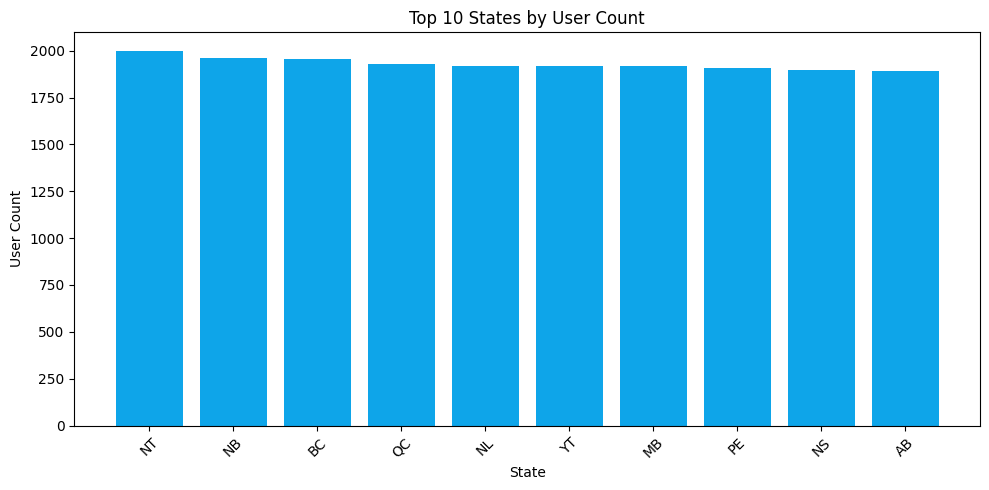

In [62]:
# Bar chart using pandas/matplotlib
import matplotlib.pyplot as plt

# Use the result from previous query
top_states = df.head(10)

plt.figure(figsize=(10, 5))
plt.bar(top_states['state'], top_states['count'], color='#0ea5e9')
plt.xlabel('State')
plt.ylabel('User Count')
plt.title('Top 10 States by User Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 9. Export Results

In [30]:
%%sql
-- Export to CSV
COPY (
    SELECT userid, username, firstname, lastname, city, state, email
    FROM users
    WHERE state = 'WA'
) TO 'output/wa_users.csv' (HEADER, DELIMITER ',')

,Success


In [31]:
%%sql
-- Export to Parquet
COPY (
    SELECT * FROM users
    WHERE likesports = true
) TO 'output/sports_fans.parquet' (FORMAT PARQUET)

,Success


## 10. Load Multiple Tables

In [32]:
def load_iceberg_table(catalog, namespace, table_name, conn):
    """Helper function to load an Iceberg table into DuckDB."""
    table = catalog.load_table(f'{namespace}.{table_name}')
    arrow_table = table.scan().to_arrow()
    conn.register(table_name, arrow_table)
    print(f"✅ Loaded {table_name} ({arrow_table.num_rows:,} rows)")
    return arrow_table

# Load all tables from a namespace
for table_info in catalog.list_tables(NAMESPACE):
    try:
        load_iceberg_table(catalog, NAMESPACE, table_info[1], conn)
    except Exception as e:
        print(f"❌ Failed to load {table_info[1]}: {e}")

✅ Loaded netflix_titles (49,990 rows)
✅ Loaded users (49,990 rows)
✅ Loaded users (49,990 rows)


In [64]:
%%sql
-- List all registered tables (including Arrow views)
SELECT table_name, table_type 
FROM information_schema.tables 
WHERE table_schema = 'main'

,table_name,table_type
0,users,VIEW


---

## What We Built

We set up a complete data lakehouse query workflow using free-tier services:

**Nessie** (on Fly.io) manages our Iceberg catalog metadata, while **Cloudflare R2** stores the actual Parquet data files. Since DuckDB's native Iceberg extension has SSL issues with R2, we use **PyIceberg** to fetch tables as Arrow format, then register them in DuckDB for blazing-fast SQL queries.

**JupySQL** lets us write clean `%%sql` cells instead of wrapping everything in Python - much nicer for exploratory analysis.

The whole stack runs on free tiers. Not bad for a production-grade lakehouse setup.